# Reviews classification

#### Data loading

* review.json is 6.3 GB and only first 500.000 records will be loaded.

In [1]:
import json 
import numpy as np
import pandas as pd

In [41]:
data_size_review = 50000

with open("../yelp_dataset/yelp_academic_dataset_review.json", 'r') as f:
    review_head = [next(f) for x in range(data_size_review)]
f.close()

review_data = []
for line in review_head:
    review_data.append(json.loads(line))

df = pd.DataFrame(review_data)

print("%i records loaded from review.json, each composed by %i columns." % (df.shape[0], df.shape[1]))

50000 records loaded from review.json, each composed by 9 columns.


#### Data preview

In [42]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,-MhfebM0QIsKt87iDN-FNw,0,2015-04-15 05:21:16,0,xQY8N_XvtGbearJ5X4QryQ,2.0,"As someone who has worked with many museums, I...",5,OwjRMXRC0KyPrIlcjaXeFQ
1,lbrU8StCq3yDfr-QMnGrmQ,0,2013-12-07 03:16:52,1,UmFMZ8PyXZTY2QcwzsfQYA,1.0,I am actually horrified this place is still in...,1,nIJD_7ZXHq-FX8byPMOkMQ
2,HQl28KMwrEKHqhFrrDqVNQ,0,2015-12-05 03:18:11,0,LG2ZaYiOgpr2DK_90pYjNw,5.0,I love Deagan's. I do. I really do. The atmosp...,1,V34qejxNsCbcgD8C0HVk-Q
3,5JxlZaqCnk1MnbgRirs40Q,0,2011-05-27 05:30:52,0,i6g_oA9Yf9Y31qt0wibXpw,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0,ofKDkJKXSKZXu5xJNGiiBQ
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4.0,"Oh happy day, finally have a Canes near my cas...",0,UgMW8bLE0QMJDCkQ1Ax5Mg


#### Building the prediction model

We want to build a deep neural network that can rate from 1 to 5 a review given in input. The model will be trained on the review data from Yelp Dataset, in which each review is associated to a star rank from 1 (bad) to 5 (good).

In [43]:
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [44]:
# to train the model we need (input, output) pairs: 
# sentences is the array of inputs and labels is the array of outputs.
sentences = []
for text in df.text:
    sentences.append(text)
    
labels = []
for star in df.stars:
    labels.append(star)
    
print(len(sentences), len(labels))

(50000, 50000)


In [45]:
size = 50000
train_size = int(size*0.9)
print(size, train_size)

(50000, 45000)


In [46]:
sentences = sentences[:size]
labels = labels[:size]

print(len(sentences), len(labels))

# split the data in (train_data, test_data)
train_sentences = sentences[:train_size]
test_sentences = sentences[train_size:]

# it's better to normalize output values to have them between 0 and 1
train_labels = np.array(labels[:train_size])/5
test_labels = np.array(labels[train_size:])/5

print(np.shape(train_sentences), np.shape(test_sentences))
print(np.shape(train_labels), np.shape(test_labels))

(50000, 50000)
((45000,), (5000,))
((45000,), (5000,))


In [71]:
vocab_size = 10000
embedding_dim = 16
max_length = 100

In [72]:
# tokenization phase, may takes few minutes

tokenizer = Tokenizer(num_words=vocab_size, oov_token="OOV")
tokenizer.fit_on_texts(train_sentences)
    
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, maxlen=max_length,
                             padding='post')

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length,
                            padding='post')

print(np.shape(train_padded))
print(np.shape(test_padded))

(45000, 100)
(5000, 100)


In [73]:
# compose the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.save_weights('my_model_weights.h5')

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d_11  (None, 16)                0         
_________________________________________________________________
dense_50 (Dense)             (None, 24)                408       
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [74]:
# train the model

epochs = [30]
history = []

for ep in epochs:
    model.load_weights('my_model_weights.h5')
    history.append(model.fit(np.array(train_padded), np.array(train_labels), epochs=ep,
                       validation_data=(test_padded, test_labels), verbose=2))

Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 - 6s - loss: 0.4660 - accuracy: 0.4364 - val_loss: 0.4152 - val_accuracy: 0.4410
Epoch 2/30
45000/45000 - 5s - loss: 0.4060 - accuracy: 0.4360 - val_loss: 0.4048 - val_accuracy: 0.4412
Epoch 3/30
45000/45000 - 6s - loss: 0.3956 - accuracy: 0.4366 - val_loss: 0.4002 - val_accuracy: 0.4408
Epoch 4/30
45000/45000 - 5s - loss: 0.3882 - accuracy: 0.4369 - val_loss: 0.3992 - val_accuracy: 0.4406
Epoch 5/30
45000/45000 - 5s - loss: 0.3829 - accuracy: 0.4370 - val_loss: 0.3991 - val_accuracy: 0.4402
Epoch 6/30
45000/45000 - 5s - loss: 0.3787 - accuracy: 0.4373 - val_loss: 0.4002 - val_accuracy: 0.4404
Epoch 7/30
45000/45000 - 5s - loss: 0.3752 - accuracy: 0.4374 - val_loss: 0.4050 - val_accuracy: 0.4392
Epoch 8/30
45000/45000 - 6s - loss: 0.3722 - accuracy: 0.4376 - val_loss: 0.4042 - val_accuracy: 0.4396
Epoch 9/30
45000/45000 - 6s - loss: 0.3695 - accuracy: 0.4377 - val_loss: 0.4073 - val_accuracy: 0.4398
Epoch 10/30
450

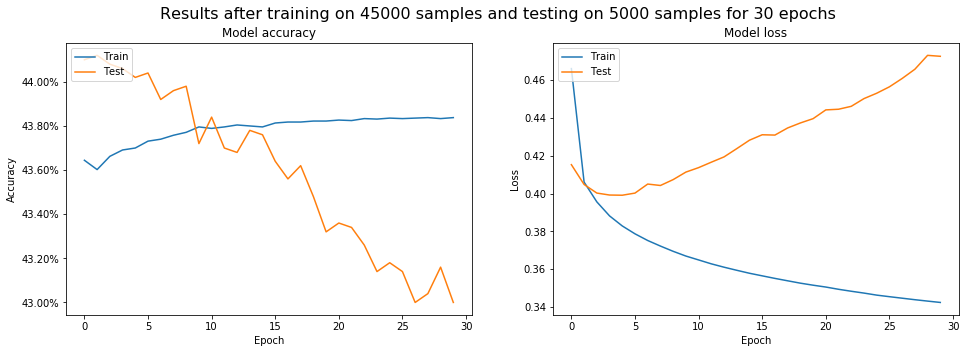

In [75]:
# print results

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


for i in range(len(history)):

    fig, axes = plt.subplots(1, 2, figsize=(16,5))
    fig.suptitle('Results after training on %i samples and testing on %i samples for %i epochs' 
                 % (train_size, size-train_size, epochs[i]), fontsize=16)

    # summarize history for accuracy
    axes[0].plot(history[i].history['accuracy'])
    axes[0].plot(history[i].history['val_accuracy'])
    axes[0].set_title('Model accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    axes[0].set_xlabel('Epoch')
    axes[0].legend(['Train', 'Test'], loc='upper left')

    # summarize history for loss
    axes[1].plot(history[i].history['loss'])
    axes[1].plot(history[i].history['val_loss'])
    axes[1].set_title('Model loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [ ]:
# make prediction

sentences_p = [
    "Horrible, this is a bad place. Disgusting",
    "I recommed to all to have a dinner here!"
]

sequences_p = tokenizer.texts_to_sequences(sentences_p)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')

result = model.predict(padded_p)

for i in range(len(result)):
    print('"%s" rating prediction is %i stars.' % (sentences_p[i], round(result[i]*5)))

In [113]:
sequences_p = tokenizer.texts_to_sequences(train_sentences)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')
result = model.predict(padded_p)

correct = 0
error1 = 0
error2 = 0
for i in range(len(result)):
    pred = round(result[i]*5)
    real = round(train_labels[i]*5)
    if pred == real:
        correct = correct + 1
    elif abs(pred-real) == 1:
        error1 = error1 + 1
    elif abs(pred-real) == 2:
        error2 = error2 + 1

print('Accuracy on train data: %f.' % (float(correct)/float(len(train_sentences))*100))
print('Error 1 on train data: %f.' % (float(error1)/float(len(train_sentences))*100))
print('Error 2 on train data: %f.' % (float(error2)/float(len(train_sentences))*100))


sequences_p = tokenizer.texts_to_sequences(test_sentences)
padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')
result = model.predict(padded_p)

correct = 0
error1 = 0
error2 = 0
error3 = 0
for i in range(len(result)):
    pred = round(result[i]*5)
    real = round(train_labels[i]*5)
    if pred == real:
        correct = correct + 1
    elif abs(pred-real) == 1:
        error1 = error1 + 1
    elif abs(pred-real) == 2:
        error2 = error2 + 1
    elif abs(pred-real) == 3:
        error3 = error3 + 1

print('Accuracy on test data: %f.' % (float(correct)/float(len(test_sentences))*100))
print('Error 1 on test data: %f.' % (float(error1)/float(len(test_sentences))*100))
print('Error 2 on test data: %f.' % (float(error2)/float(len(test_sentences))*100))
print('Error 3 on test data: %f.' % (float(error3)/float(len(test_sentences))*100))

Accuracy on train data: 86.968889.
Error 1 on train data: 12.742222.
Error 2 on train data: 0.271111.
Accuracy on test data: 28.060000.
Error 1 on test data: 28.840000.
Error 2 on test data: 17.360000.
Error 3 on test data: 14.700000.


In [127]:
# try dropout to improve results

def dropout(sentence, label):
    sequences_p = tokenizer.texts_to_sequences([sentence])
    padded_p = pad_sequences(sequences_p, maxlen=max_length, padding='post')
    result = model.predict(padded_p)
    return round(result[0][0]*5) == label*5

print(dropout(train_sentences[0], train_labels[0]))

True
